# Grade scale

Description of the data 15%

Text preprocessing 30%

Algorithm implementation 25%

Description of the findings 30%


Checklist to have in mind

Describe your data. What are the variables you are working with? Are there missing values? Are there wrongly encoded data? Describe how you approached fixing these issues (if applicable).

In your specific case, does it make sense to remove numeric characters, punctuation, stopwords, lemmatize, or stem the tokens? Would it make more sense to use single tokens, bigrams or n-ngrams? Argue why you are making certain choices rather than others.

What are the features of the algorithm that you are using?

Describe your findings. What do they say? How to interpret the results? How would (how do) your results change if you improve pre-processing?


# COVID-19 Text and Sentiment Analysis
github repo: https://github.com/dgulacsy/covid19_text_analysis

# Data Description

## Source
My data is coming from a dataset I found on [Kaggle](https://www.kaggle.com/kaushiksuresh147/covidvaccine-tweets). It contains data on tweets from Twitter using the hashtag #CovidVaccine.

## Variables

| No | Columns          | Descriptions                                                                                | Example                                                                                                                                  |
|----|------------------|---------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------|
| 1  | user_name        | The name of the user, as they’ve   defined it.                                              | MyNewsNE                                                                                                                                 |
| 2  | user_location    | The user-defined location for   this account’s profile.                                     | Assam                                                                                                                                    |
| 3  | user_description | The user-defined UTF-8 string   describing their account.                                   | MyNewsNE a dedicated   multi-lingual media house from North Eastern India.                                                               |
| 4  | user_created     | Time and date, when the account   was created.                                              | 43975.42917                                                                                                                              |
| 5  | user_followers   | The number of followers a   account currently has.                                          | 64                                                                                                                                       |
| 6  | user_friends     | The number of friends a account   currently has.                                            | 11                                                                                                                                       |
| 7  | user_favourites  | The number of favorites a   account currently has                                           | 110                                                                                                                                      |
| 8  | user_verified    | When true, indicates that the   user has a verified account                                 | FALSE                                                                                                                                    |
| 9  | date             | UTC time and date when the Tweet   was created                                              | 44061.53819                                                                                                                              |
| 10 | text             | The actual UTF-8 text of the   Tweet                                                        | Australia to Manufacture   Covid-19 Vaccine and give it to the Citizens for free of cost: AFP quotes   Prime Minister      #CovidVaccine |
| 11 | hashtags         | All the other hashtags posted in   the tweet along with #CovidVaccine                       | ['CovidVaccine']                                                                                                                         |
| 12 | source           | Utility used to post the Tweet,   Tweets from the Twitter website have a source value - web | Twitter Web App                                                                                                                          |
| 13 | is_retweet       | Indicates whether this Tweet has   been Retweeted by the authenticating user.               | FALSE                                                                                                                                    |

## Examples
1. Anti-vacciner post
![anti.jpg](pics/anti.JPG)

2. Pro-vacciner post
![pro.jpg](pics/pro.JPG)

## Research intention
My aim with this analysis is to estimate the public's opinion on COVID-19 vaccination. Shedding more light how people are feeling about the situation by applying sentiment analysis on their tweets' text body. I also carry out explanatory data analysis and text clustering to better understand the topic of the tweets. Some further applications may be to gain some insight on which administrations should make a move as anti-vaccination groups are getting more vigilant on media outlets and starting to organize anti-vaccination protests. But that does not form a part of this work yet.

## Data Extraction

During my analysis I work with the following columns in the data:
1. user_created - to filter for user accounts that were created befor 2015 (to lower the number of bot accounts)
2. date - to visualize trends over time in tweet sentiment
3. text - to calculate the sentiment score of tweet

In [1]:
# Importing Libraries
# General
from datetime import datetime as dt, timedelta as td
import re
# Data manipulation
import pandas as pd
import csv
# NLP
import nltk
from nltk.tokenize import word_tokenize as wt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
#nltk.download('vader_lexicon')
# Visualizations
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
#matplotlib.use('SVG')

In [2]:
# Loading tweets
tweets = pd.read_csv("data/raw/covidvaccine.csv",parse_dates=['date','user_created'])
# Dropping unneccesary columns
tweets = tweets[['user_created', 'date', 'text', 'hashtags']]

# Getting rid of user accounts that were created before 2015 to lower bot activ
tweets = tweets.loc[tweets["user_created"] <= "2015-01-01"]
tweets = tweets.drop(columns="user_created")

# Converting time from UTC to CEST +2 hours
#cest_dates=[]
#for date in tweets['date']:
#    cest_dates.append(date+td(hours=2))
#tweets['date']=cest_dates

In [3]:
tweets.head(100)

,date,text,hashtags
4,2020-08-18 12:45:00,@michellegrattan @ConversationEDU This is what...,NaN
6,2020-08-18 12:34:00,@PrivilRodrigues @yatish57 @deepkaranahuja @sh...,NaN
8,2020-08-18 12:15:00,"Most countries, without the ability to make #V...",['Vaccines']
10,2020-08-18 11:12:00,Biocon Executive Chairperson Kiran Mazumdar Sh...,NaN
14,2020-08-18 10:39:00,The whole narrative on the #CovidVaccine has g...,"['CovidVaccine', 'ChinaVirus', 'COVID19India']"
...,...,...,...
200,2020-08-16 20:45:00,@Jaywalk90075373 @GavinNewsom It's nuts and no...,NaN
201,2020-08-16 20:41:00,#Russia’s new Sputnik launch raises risks in d...,"['Russia', 'CovidVaccine']"
202,2020-08-16 20:02:00,@TimesNow This man has got a verbal diarrhea.....,['CovidVaccine']
204,2020-08-16 19:20:00,An important part of science is admitting when...,['VaccineTrials']


My data does not suffer from any encoding problems, even emoticons are encoded well. So as far as encoding, there is nothing to do with this dataset. It is likely that it was already UTF-8 encoded.

In [4]:
" ".join(tweet for tweet in tweets.text)

'@michellegrattan @ConversationEDU This is what passes for leadership in our country: a voucher for something that w… https://t.co/OUUb1PeYIj @PrivilRodrigues @yatish57 @deepkaranahuja @shristi522 @Amrita33392520 @RashmiSriniva14 @AkashRK_88 @SJanaQA… https://t.co/VPLa11fwfr Most countries, without the ability to make #Vaccines locally, will be forced to rely on others like the US, China,… https://t.co/QUCozLB4Ru Biocon Executive Chairperson Kiran Mazumdar Shaw contracts coronavirus, informs on Twitter… https://t.co/eojjwPsw11 The whole narrative on the #CovidVaccine has gone deathly silent! #ChinaVirus #COVID19India .@SerumInstIndia is looking to raise up to $1 billion (around Rs 7,500 crore) for Covid-19 vaccine development. Det… https://t.co/LTXSkBcI90 Search chennai corona affected street or area wise https://t.co/eqIPQlcCoP \n\n#CovidVaccine #Covid19Chennai #COVID19… https://t.co/atfmdDFHrQ How will be vaccinate the world?\n#vacine #vaccinate #coronavirus\n#covidvaccine \nSource: 

Number of tweets without any text: 0 / 12578
Number of tweets without any hashtags: 3624 / 12578  =  0.29 %


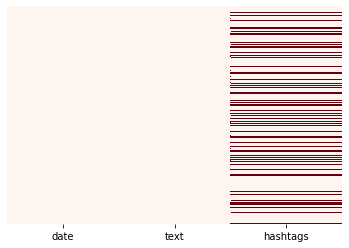

In [5]:
# Visualize missing values
print("Number of tweets without any text:",len(tweets[tweets['text'].isna()]), "/", len(tweets))
print("Number of tweets without any hashtags:",len(tweets[tweets['hashtags'].isna()]),"/", len(tweets), ' = ' ,round(3624/12578,2),"%")
sns.heatmap(tweets.isnull(), cmap="Reds", cbar=False, yticklabels=False)

Data also looks great from the point of view that there are no tweets with missing text. There are some tweets that have no hashtags at all but the share of them is negliable (0.29%).

# Text Preprocessing

In [6]:
def preprocess(text):
    text = re.sub(r'https.*?\s','',text.lower()) # remove links
    text = re.sub(r'[^a-z\s]','',text) # remove any non-alphabetical superflous whitespace character
    return text

In my preprocessing function I remove all the links by matching the https protocol prefix, I also remove any non-alphabetical characters and unnecessary whitespace. This will be useful to fit the KNN algroithm to find the text clusters as these procedures produces much better result if the dimensionality of the data is reduced by thoughtful lemmatization and stopword removal. But I won't use it for senitment analysis as the VADER sentiment analyzer makes use of emoticons, capitalization, punctuation and intensifiers.

# Explanatory Data Analysis

In [7]:
# Preparing the text
t = " ".join(tweet for tweet in tweets.text)
print ('There are %s words in the combination of all tweets.' % (len(t)))
text = preprocess(t)
print ('There are %s tokenized words in the combination of all tweets.' % (len(text)))

There are 1617460 words in the combination of all tweets.
There are 1234725 tokenized words in the combination of all tweets.


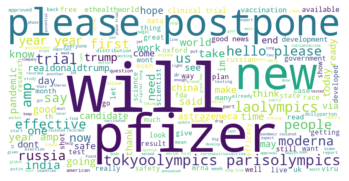

In [8]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords_raw=['covidvaccine', 'covid','vaccine','vaccines','coronavirus']
stopwords_splited=[]
for phrase in stopwords_raw:
    split=phrase.split()
    stopwords_splited=list(set(stopwords_splited+split))
stopwords.update(stopwords_splited)

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white",width=800, height=400).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
fig = plt.gcf() #get current figure
#plt.show(fig)
#fig.set_size_inches(10,10)
#plt.savefig("pics/tweets_word_cloud.png", format="png")

As it can be seen on this wordcloud the most common words are pfizer, will, new, postpone and some other words about the olympics. So the most a majority of the tweets are about the postponement of the olympics and the Pfizer vaccine.

In [9]:
# Tokenize text
stop_words = nltk.corpus.stopwords.words('english')
stop_words.append('http')
stop_words.append('https')
def tokenize(text):
    words = wt(text)
    tokens = [word for word in words if word not in stop_words] # remove extended stopwords
    stemmer = nltk.stem.LancasterStemmer() 
    stems = [stemmer.stem(word) for word in tokens]
    return stems

I used tokenization and stemming as this ensures that the clustering algorithms provide better results. I think user more than bigrams do not necessarily help much in this case as tweets are rather short texts so their structure is much simpler as well.

In [10]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize, ngram_range=(1,2))

In [11]:
# Preprocess tweets as a document list
tweet_list = list(tweets.text)
tweet_list = list(map(lambda x: preprocess(x),tweet_list))
tweet_list

['michellegrattan conversationedu this is what passes for leadership in our country a voucher for something that w httpstcoouubpeyij',
 'privilrodrigues yatish deepkaranahuja shristi amrita rashmisriniva akashrk sjanaqa httpstcovplafwfr',
 'most countries without the ability to make vaccines locally will be forced to rely on others like the us china httpstcoqucozlbru',
 'biocon executive chairperson kiran mazumdar shaw contracts coronavirus informs on twitter httpstcoeojjwpsw',
 'the whole narrative on the covidvaccine has gone deathly silent chinavirus covidindia',
 'seruminstindia is looking to raise up to  billion around rs  crore for covid vaccine development det httpstcoltxskbci',
 'search chennai corona affected street or area wise \n\ncovidvaccine covidchennai covid httpstcoatfmddfhrq',
 'how will be vaccinate the world\nvacine vaccinate coronavirus\ncovidvaccine \nsource bbcnews design mark hall httpstcolaginunzb',
 'covid pune study shows seroprevalence of antibodies in  sampl

In [12]:
X = tfidf_vectorizer.fit_transform(tweet_list)

In [13]:
true_k = 3
model = KMeans(n_clusters=true_k, init='k-means++', random_state = 4)

In [14]:
model.fit(X)
clusters = model.fit_predict(X)

In [15]:
# Show the 3 text clusters
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Cluster 0:
 record
 song
 origin song
 record origin
 song coronavir
 pandem isol
 origin
 coronavir pandem
 isol
 isol record
Cluster 1:
 year
 tokyoolymp parisolymp
 parisolymp
 postpon tokyoolymp
 tokyoolymp
 pleas postpon
 postpon
 parisolymp laolymp
 laolymp
 pleas
Cluster 2:
 covidvaccin
 vaccin
 covid
 covid vaccin
 pfiz
 new
 tri
 covid covidvaccin
 get
 coronavir


The three main cluster are aligned with the conlusion drawn from the wordcloud. Tweets are mainly about the promising pfizer vaccine, the postponement of olympics but the third cluster is kind of a surprise. It represents the group of tweets that are about song written about social isolation due to COVID which was interesting to me because I did not know at all about this trend before.

# Algorithm Implementation

In [16]:
tweets = tweets[['date', 'text']]

# Initializing Sentiment Analyzer Object
sia=SentimentIntensityAnalyzer()

# Calculate Sentiment Score for tweets one by one
tweets['compound_sentiment']=tweets['text'].apply(lambda x: sia.polarity_scores(str(x))['compound'])
tweets['neutral'] = tweets['text'].apply(lambda x: sia.polarity_scores(str(x))['neu'])
tweets['negative'] = tweets['text'].apply(lambda x: sia.polarity_scores(str(x))['neg'])
tweets['positive'] = tweets['text'].apply(lambda x: sia.polarity_scores(str(x))['pos'])

In [17]:
tweets.head()

,date,text,compound_sentiment,neutral,negative,positive
4,2020-08-18 12:45:00,@michellegrattan @ConversationEDU This is what...,0.0000,1.000,0.000,0.000
6,2020-08-18 12:34:00,@PrivilRodrigues @yatish57 @deepkaranahuja @sh...,0.0000,1.000,0.000,0.000
8,2020-08-18 12:15:00,"Most countries, without the ability to make #V...",-0.3532,0.707,0.195,0.098
10,2020-08-18 11:12:00,Biocon Executive Chairperson Kiran Mazumdar Sh...,0.0000,1.000,0.000,0.000
14,2020-08-18 10:39:00,The whole narrative on the #CovidVaccine has g...,0.0000,1.000,0.000,0.000


In [18]:
tweets['sentiment']=''
tweets.loc[tweets.compound_sentiment>0.05,'sentiment']='Positive'
tweets.loc[(tweets.compound_sentiment>-0.05) & (tweets.compound_sentiment<0.05),'sentiment']='Neutral'
tweets.loc[tweets.compound_sentiment<-0.05,'sentiment']='Negative'

In [19]:
tweets.head()

,date,text,compound_sentiment,neutral,negative,positive,sentiment
4,2020-08-18 12:45:00,@michellegrattan @ConversationEDU This is what...,0.0000,1.000,0.000,0.000,Neutral
6,2020-08-18 12:34:00,@PrivilRodrigues @yatish57 @deepkaranahuja @sh...,0.0000,1.000,0.000,0.000,Neutral
8,2020-08-18 12:15:00,"Most countries, without the ability to make #V...",-0.3532,0.707,0.195,0.098,Negative
10,2020-08-18 11:12:00,Biocon Executive Chairperson Kiran Mazumdar Sh...,0.0000,1.000,0.000,0.000,Neutral
14,2020-08-18 10:39:00,The whole narrative on the #CovidVaccine has g...,0.0000,1.000,0.000,0.000,Neutral


I ran the VADER sentiment analyzer on each tweet to get its sentiments score measured using 3 seperate dimensions which are negativity, neutrality and positivity. Plus it also provides a compound score based on which one can categorize the tweets into the most dominating sentiment dimension. As I mention the text was not preprocessed as VADER works best if the source text contains these nuances (emoticons, punctiation, intensifiers) that make it highly performant. 

# Findings

### Look at sentiment distribution of tweets

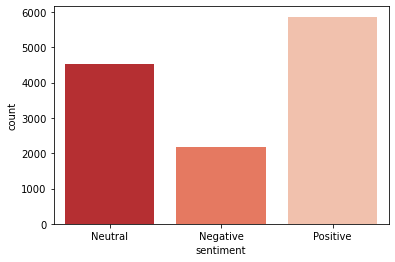

In [20]:
sns.countplot(x='sentiment', data=tweets, palette="Reds_r")

As it can be seen on this bar chart most tweets had a positive sentiment then about 4500 tweets had an overall neutral sentiment while only about 2300 tweets had an overall negative sentiment. It is quite surprising to me as I expected that negative tweets will dominate. However this may have to do something with Twitter's strict hate speech and misinformation screening procedure that may have filtered out many negatively oriented tweets.

### Look at Sentiment Trend over time

In [21]:
# Set dates as index
tweets_ts = tweets.set_index('date')
tweets_ts

,text,compound_sentiment,neutral,negative,positive,sentiment
date,,,,,,
2020-08-18 12:45:00,@michellegrattan @ConversationEDU This is what...,0.0000,1.000,0.000,0.000,Neutral
2020-08-18 12:34:00,@PrivilRodrigues @yatish57 @deepkaranahuja @sh...,0.0000,1.000,0.000,0.000,Neutral
2020-08-18 12:15:00,"Most countries, without the ability to make #V...",-0.3532,0.707,0.195,0.098,Negative
2020-08-18 11:12:00,Biocon Executive Chairperson Kiran Mazumdar Sh...,0.0000,1.000,0.000,0.000,Neutral
2020-08-18 10:39:00,The whole narrative on the #CovidVaccine has g...,0.0000,1.000,0.000,0.000,Neutral
...,...,...,...,...,...,...
2020-11-17 00:09:00,#COVID19 #CovidVaccine #vaccine #vaccines #Vac...,0.0000,1.000,0.000,0.000,Neutral
2020-11-17 00:07:00,@JoeBiden @KamalaHarris Thank you @realDonaldT...,0.3612,0.800,0.000,0.200,Positive
2020-11-17 00:01:00,Nanoparticles are on the rise. Both Pfizer/Bio...,0.0000,1.000,0.000,0.000,Neutral


In [25]:
def get_sentiment_trends(freq, data):
    # Aggregate tweets to a given timewindow
    data = data.set_index('date')
    data = data.resample(freq, label="right").mean()
    data = data.reset_index()
    fig, ax = plt.subplots(figsize=(18,10))
    sns.lineplot(ax=ax, x='date', y='value', hue='variable', 
                 data=pd.melt(data, ['date']))

These graphs depict the sentiment trends one by one and combined using different frequencies to aggregate the tweet-level data to time-period-level data:

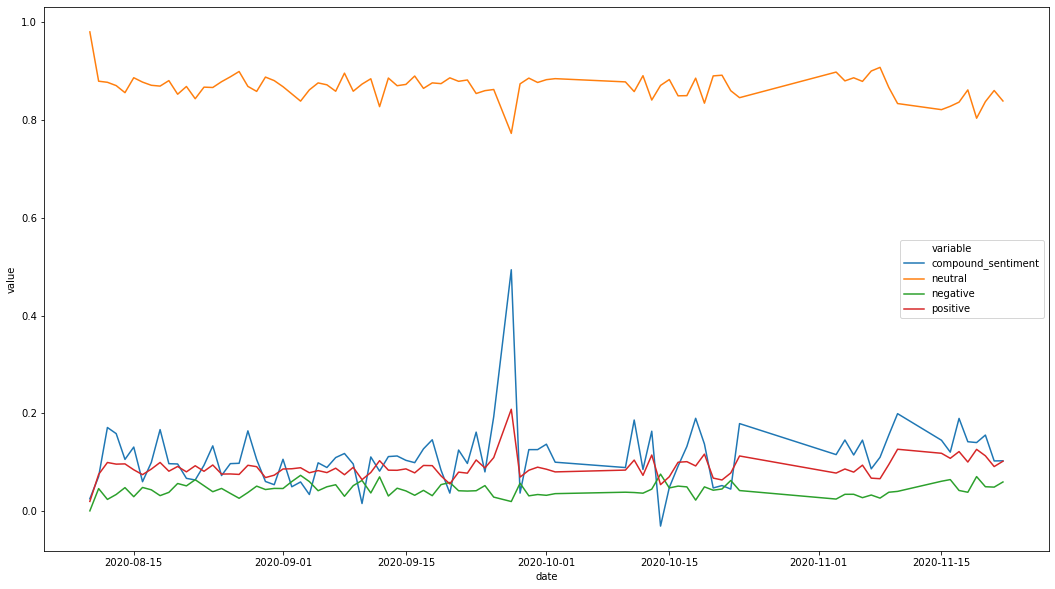

In [26]:
# 1 day Frequency
freq=td(days=1)
get_sentiment_trends(freq,tweets)

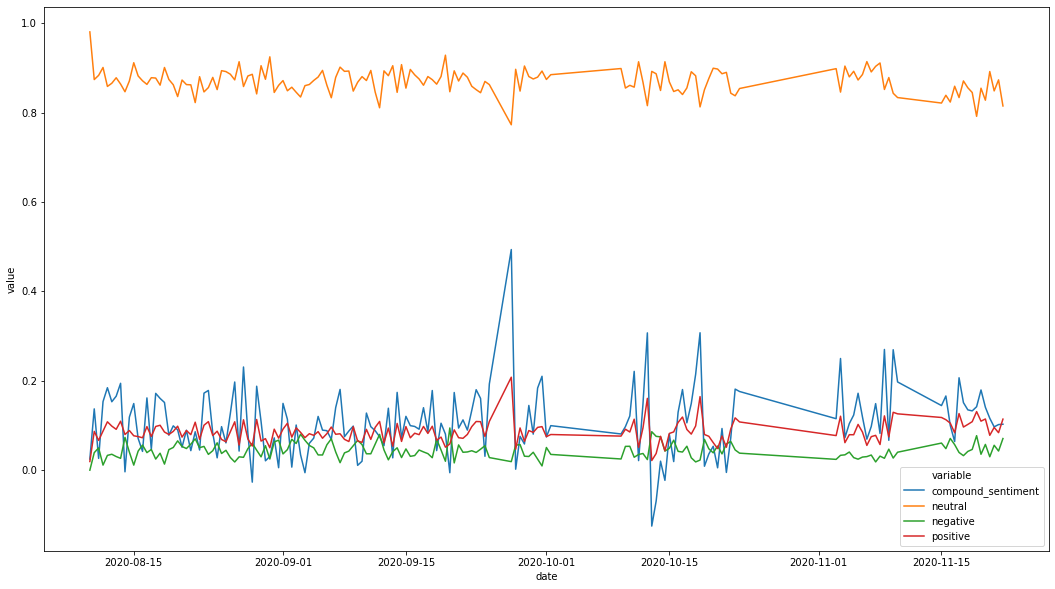

In [27]:
# 12 hours frequency
freq=td(hours=12)
get_sentiment_trends(freq,tweets)

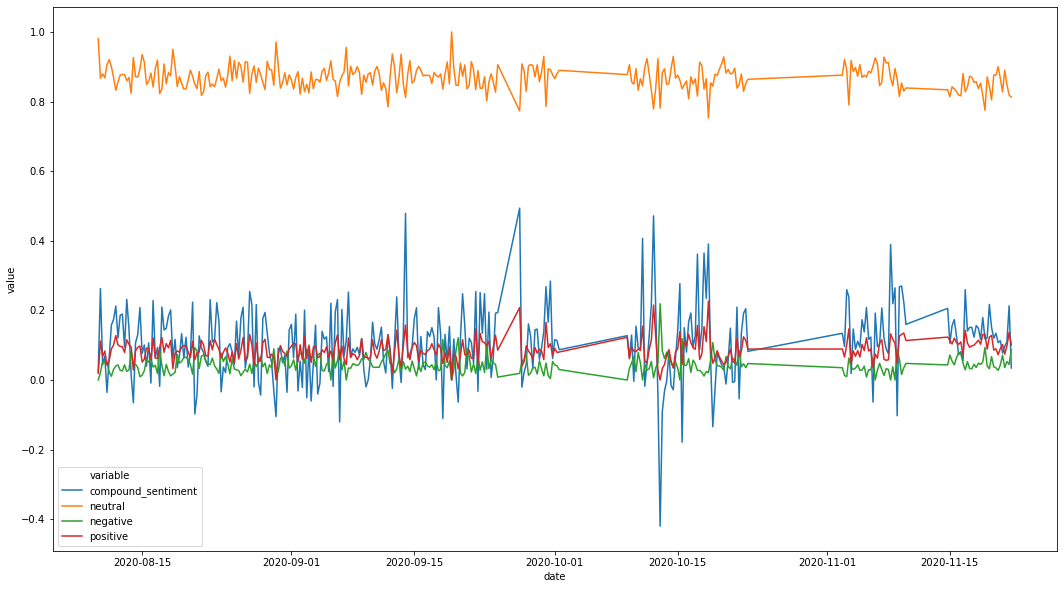

In [30]:
# 1 hour frequency
freq=td(hours=6)
get_sentiment_trends(freq,tweets)

As we can see on each graph there is no clear trend in the sentiment. Their variance change with the frequency but that's just because the average number of tweets included in one time period decreased. However, there are some spikes in the graph, mostly prominently around Oct 13 (maybe some bad news about COVID) and 18 (maybe some good news about COVID) and a remarkable upswing in sentiment at the end of September. As far as preprocessing, these result may better reflect the truth in the underlying data if we could filter out somehow more efficiently those tweets that are highly likely to be posted by bot accounts. 